# Homework 6

## Rui Fang $\quad$ Collaborator: Yijun Shen

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 9th, 2018 at 11:00am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Metropolis and Chill

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you might not recall the correct order, but the mistakes you will tend to make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *Wonder Woman*
4. *Black Panther*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *Wonder Woman*
5. *Pulp Fiction*
4. *Black Panther*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Now, we have a way of quantifying how wrong your answer can be. We define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is the indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *Black Panther* in both answers correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}.$$

### Part A:

Implement an Metropolis algorithm to produce sample guesses from 500 individuals, with various $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

***

### *Solution*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from collections import Counter
import math
import seaborn as sns

%matplotlib notebook

sns.set()

In [177]:
# Correct ranking order
omega = np.array([1, 2, 3, 4, 5])

# Hamming distance between an arbitrary ranking to the correct ranking 
H_distance = lambda theta: sum(theta != omega)

# Probability of giving a particular ranking 
pdf = lambda theta, lmd: np.exp(-lmd * H_distance(theta))

# Function to implement Metropolis algorithm (adapted from example code given in lecture) 
def metropolis(p, qdraw, nsamp, xinit):
    samples = []
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples.append(x_star)
            x_prev = x_star
            accepted += 1
        else:  # we always get a sample
            samples.append(x_prev)
            
    return samples, accepted

In [191]:
# Sample 500 guesses with lmd=0.2, 0.5, 1.0

theta_init = np.random.permutation(omega)
n_samples = 5000
burnin = n_samples-500

print('Top 5 possible guesses and their counts:')

for lmd in [0.2, 0.5, 1.0]:
    
    samps, _ = metropolis(partial(pdf, lmd=lmd), np.random.permutation, n_samples, theta_init)
    
    print('-------------------------------------------')
    print('for lambda=%s'%lmd)
    for elem in Counter(tuple(map(tuple, samps[burnin:]))).most_common(5):
        print(elem)

Top 5 possible guesses and their counts:
-------------------------------------------
for lambda=0.2
((1, 3, 4, 2, 5), 13)
((1, 2, 5, 4, 3), 11)
((1, 4, 3, 5, 2), 10)
((5, 2, 3, 4, 1), 9)
((5, 2, 4, 1, 3), 8)
-------------------------------------------
for lambda=0.5
((1, 2, 3, 4, 5), 41)
((5, 2, 3, 4, 1), 23)
((2, 5, 3, 4, 1), 14)
((2, 4, 3, 1, 5), 12)
((2, 1, 3, 4, 5), 12)
-------------------------------------------
for lambda=1.0
((1, 2, 3, 4, 5), 147)
((1, 2, 4, 3, 5), 26)
((4, 2, 3, 1, 5), 21)
((3, 2, 1, 4, 5), 19)
((1, 4, 3, 5, 2), 15)


***

### Part B:
Using the Metropolis algorithm, compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) . Compare the resulting probabilities for the various different $\lambda$ values. Summarize your findings.

***

### *Solution*

In [193]:
theta_init = np.random.permutation(omega)
n_samples = 10000

print('Probability that The Shawshank Redemption is ranked as the top movie:') 

for lmd in [0.2, 0.5, 1.0, 1.5, 2.0]:
    
    samps, _ = metropolis(partial(pdf, lmd=lmd), np.random.permutation, n_samples, theta_init)
    Shawshank_prob = Counter(np.array(samps)[:, 0])[1]/n_samples
    print('%s for lambda=%s' % (Shawshank_prob, lmd))

Probability that The Shawshank Redemption is ranked as the top movie:
0.2453 for lambda=0.2
0.3312 for lambda=0.5
0.4919 for lambda=1.0
0.8177 for lambda=1.5
0.9155 for lambda=2.0


As shown above, the resulting probabilities increases for incresasing $\lambda$. This makes sense because the bigger the $\lambda$, the smaller the probability $p(\theta \,|\, \omega, \lambda)$ for positive $d(\theta,\, \omega)$. Thus The Shawshank Redemption is more likely to be ranked correctly (ranked number 1). 

***

## Problem 2: Lensed Galaxies via Metropolis-Hastings

You are a renowned observational astronomer working on gravitational lensing and you just got news about a source whose morphology appears distorted, most likely because there is a foreground source (an ensemble of mini black holes for which you know the mass and position) acting as a lens. Your gravitational lensing calculations indicate that the detected flux $F$ from the background source as a function of right ascencion ($x$) and declination ($y$) can be described by a modified Beale's function:

$F(x,y) = \exp\left[-\left(\frac{x^2}{2\sigma_x^2}+\frac{y^2}{2\sigma_y^2}\right)\right] \log (1.0+(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2) $

with $\sigma_x = \sigma_y = \sqrt{10}$

You are interested in observing this source with the Hubble Space Telescope, and you want to simulate beforehand how photons will form the image on the Hubble detector. You realize that a good way to do this is by sampling F(x,y) with a Monte Carlo method.

### Part A:

Using the following asymmetric function as a proposal distribution:

$q(x,y) = \frac{1}{\sqrt{2 \pi \gamma_1\gamma_2}} {\rm exp}\left[-\left(\frac{(x-0.1)^2}{2 \gamma_1^2} + \frac{(y-0.1)^2}{2 \gamma_2^2}\right) \right] $ 

with $\gamma_1 = 1.0\beta$, $\gamma_2 = 1.5\beta$, and $\beta=1$ (x and y are the coordinates of the proposed step if we center the coordinate system in our current position.)

construct a Metropolis-Hastings algorithm to produce $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.

*** 

### *Solution*

In [62]:
from scipy.stats import multivariate_normal

def F(x_prev):
    x, y = x_prev[0], x_prev[1]
    return np.exp(-(x**2+y**2)/20.) * np.log(1. + (1.5-x+x*y)**2 + (2.25-x+x*y**2)**2 + (2.625-x+x*y**3)**2)

def q_pdf(x_new, x_old, beta):
    gamma1 = beta
    gamma2 = 1.5*beta
    mean = np.array([0.1, 0.1])
    cov = np.array([[gamma1**2, 0], [0, gamma2**2]])
    return multivariate_normal.pdf(x_new-x_old, mean=mean, cov=cov)

def q_draw(x_old, beta):
    gamma1 = beta
    gamma2 = 1.5*beta
    mean = np.array([0.1, 0.1])
    cov = np.array([[gamma1**2, 0], [0, gamma2**2]])
    return x_old + multivariate_normal.rvs(mean=mean, cov=cov)

# Function to implement Metropolis-Hastings (adapted from example code given in lecture) 
def metropolis_hastings(p, q, qdraw, nsamp, xinit):
    samples = []
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        proposalratio = q(x_prev, x_star)/q(x_star, x_prev)
        if np.random.uniform() < min(1, pdfratio*proposalratio):
            samples.append(x_star)
            x_prev = x_star
            accepted += 1
        else:  # we always get a sample
            samples.append(x_prev)
            
    return samples, accepted

In [158]:
# Produce N=100000 samples from F(x,y) with initial (x,y)=(5,-5), beta=1

N = 100000
beta = 1
x_init = np.array([5, -5])

samps, acc = metropolis_hastings(F, partial(q_pdf, beta=beta), partial(q_draw, beta=beta), N, x_init)

<IPython.core.display.Javascript object>


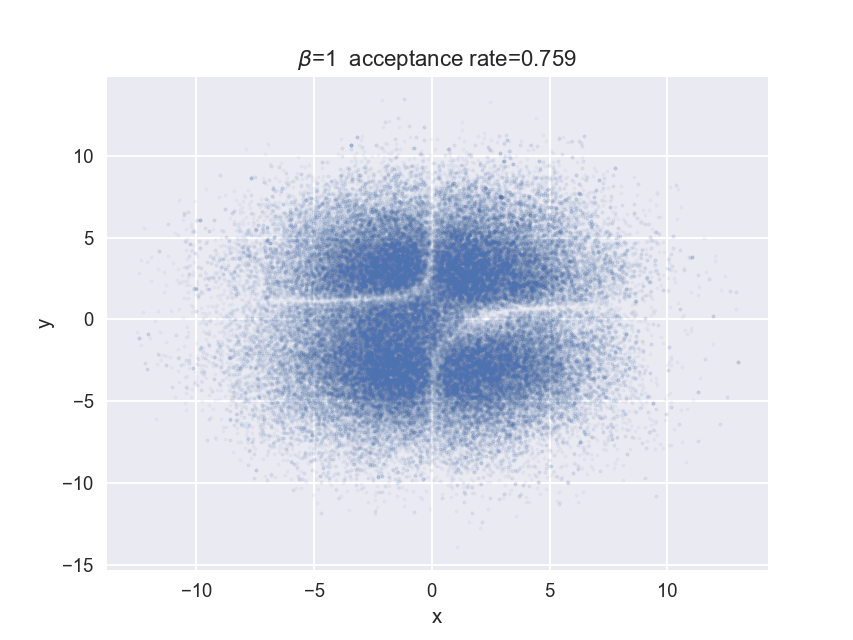

In [159]:
# Plot results 

X = np.array(samps)[:, 0]
Y = np.array(samps)[:, 1]

plt.figure()
plt.scatter(X, Y, s=3, alpha=0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'$\beta$=%s  acceptance rate=%.3f' % (beta, acc/N))
plt.show()

***

### Part B:

We want to experiment with $\beta$ by running your code with $\beta$ in the range 0.1 to 40 (think about the appropriate order of magnitude of the $\beta$ spacing). 

1. Plot the accepted sample histories for each $\beta$. What is the acceptance rate for each $\beta$? 
2. Explain your results and select the "best" value of $\beta$?

***
### *Solution*

In [120]:
# Run the code with beta in range [0.1, 40]

all_results = []

N = 100000
x_init = np.array([5, -5])

for beta in [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 40]:
    samps, acc = metropolis_hastings(F, partial(q_pdf, beta=beta), partial(q_draw, beta=beta), N, x_init)
    all_results.append([beta, samps, acc])

<IPython.core.display.Javascript object>


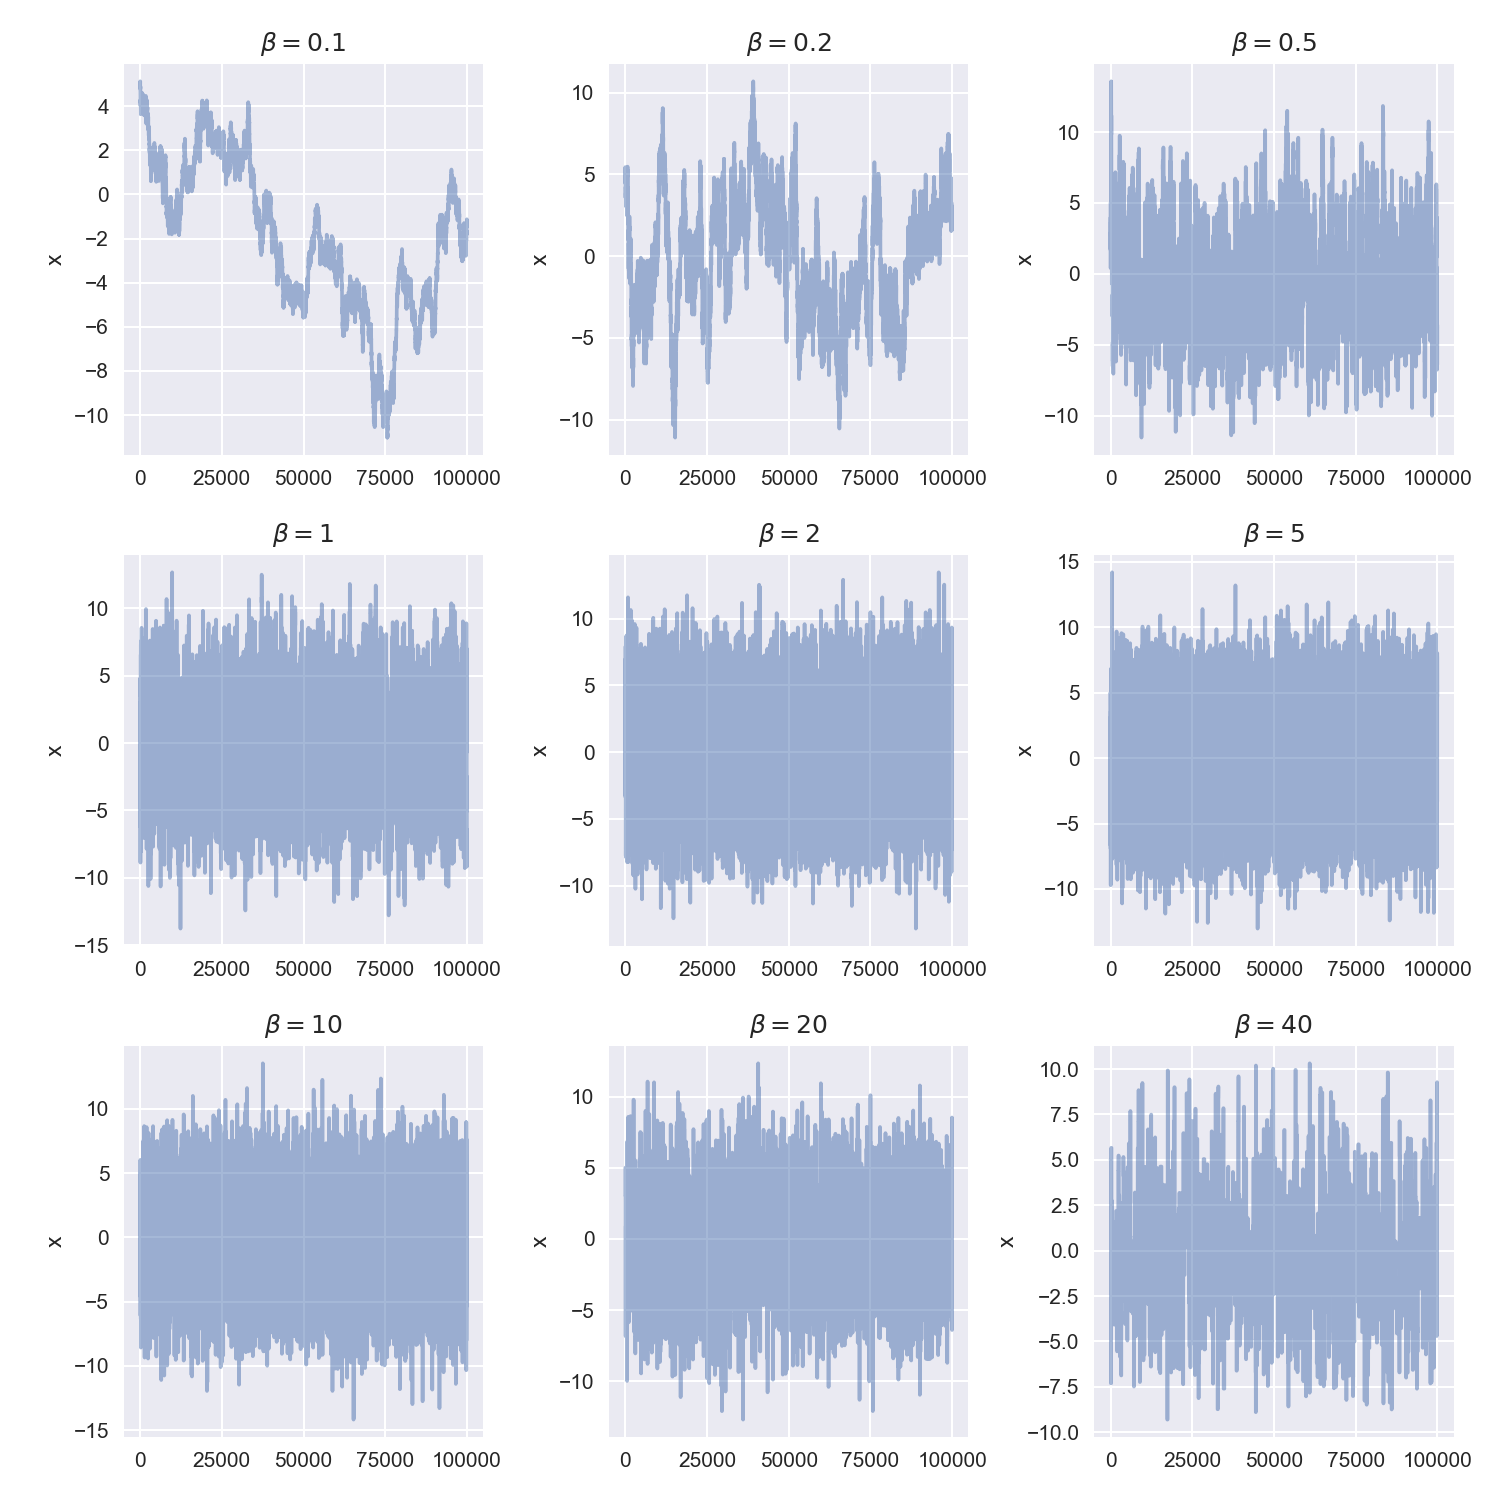

<IPython.core.display.Javascript object>


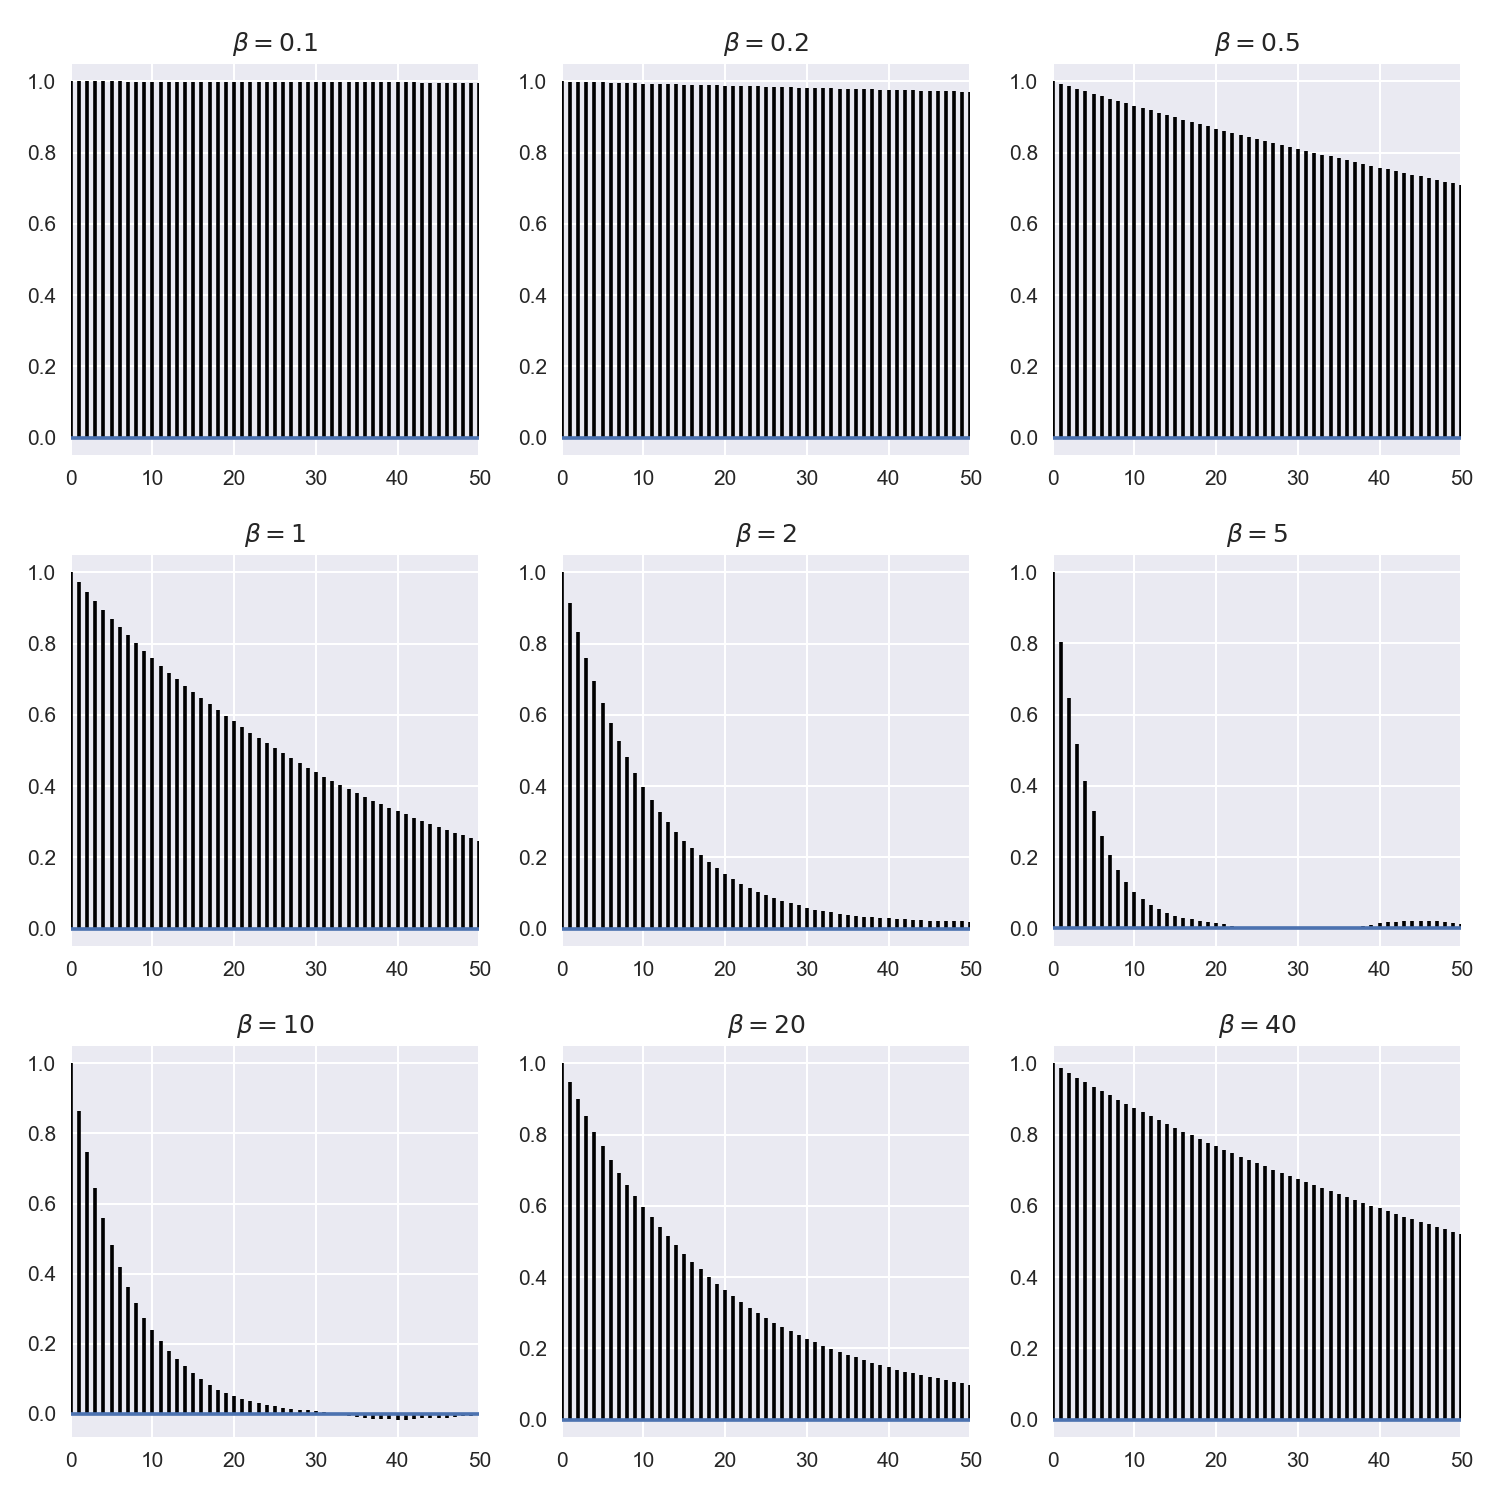

In [160]:
# Make trace plot of x and check autocorrelation for each beta 

maxlags = 50
fig1, axes1 = plt.subplots(3, 3, figsize=(10, 10))
fig2, axes2 = plt.subplots(3, 3, figsize=(10, 10))

for i in range(len(all_results)):
    samps = all_results[i][1]
    X = np.array(samps)[:, 0]
    
    ax = axes1.flatten()[i]
    ax.plot(X, alpha=0.5)
    ax.set_ylabel('x')
    ax.set_title(r'$\beta=%s$' % (all_results[i][0]))
    
    ax = axes2.flatten()[i]
    ax.acorr(X-np.mean(X),  normed=True, maxlags=maxlags);
    ax.set_xlim([0, maxlags])
    ax.set_title(r'$\beta=%s$' % (all_results[i][0]))

fig1.tight_layout()    
fig2.tight_layout()    
plt.show()

<IPython.core.display.Javascript object>


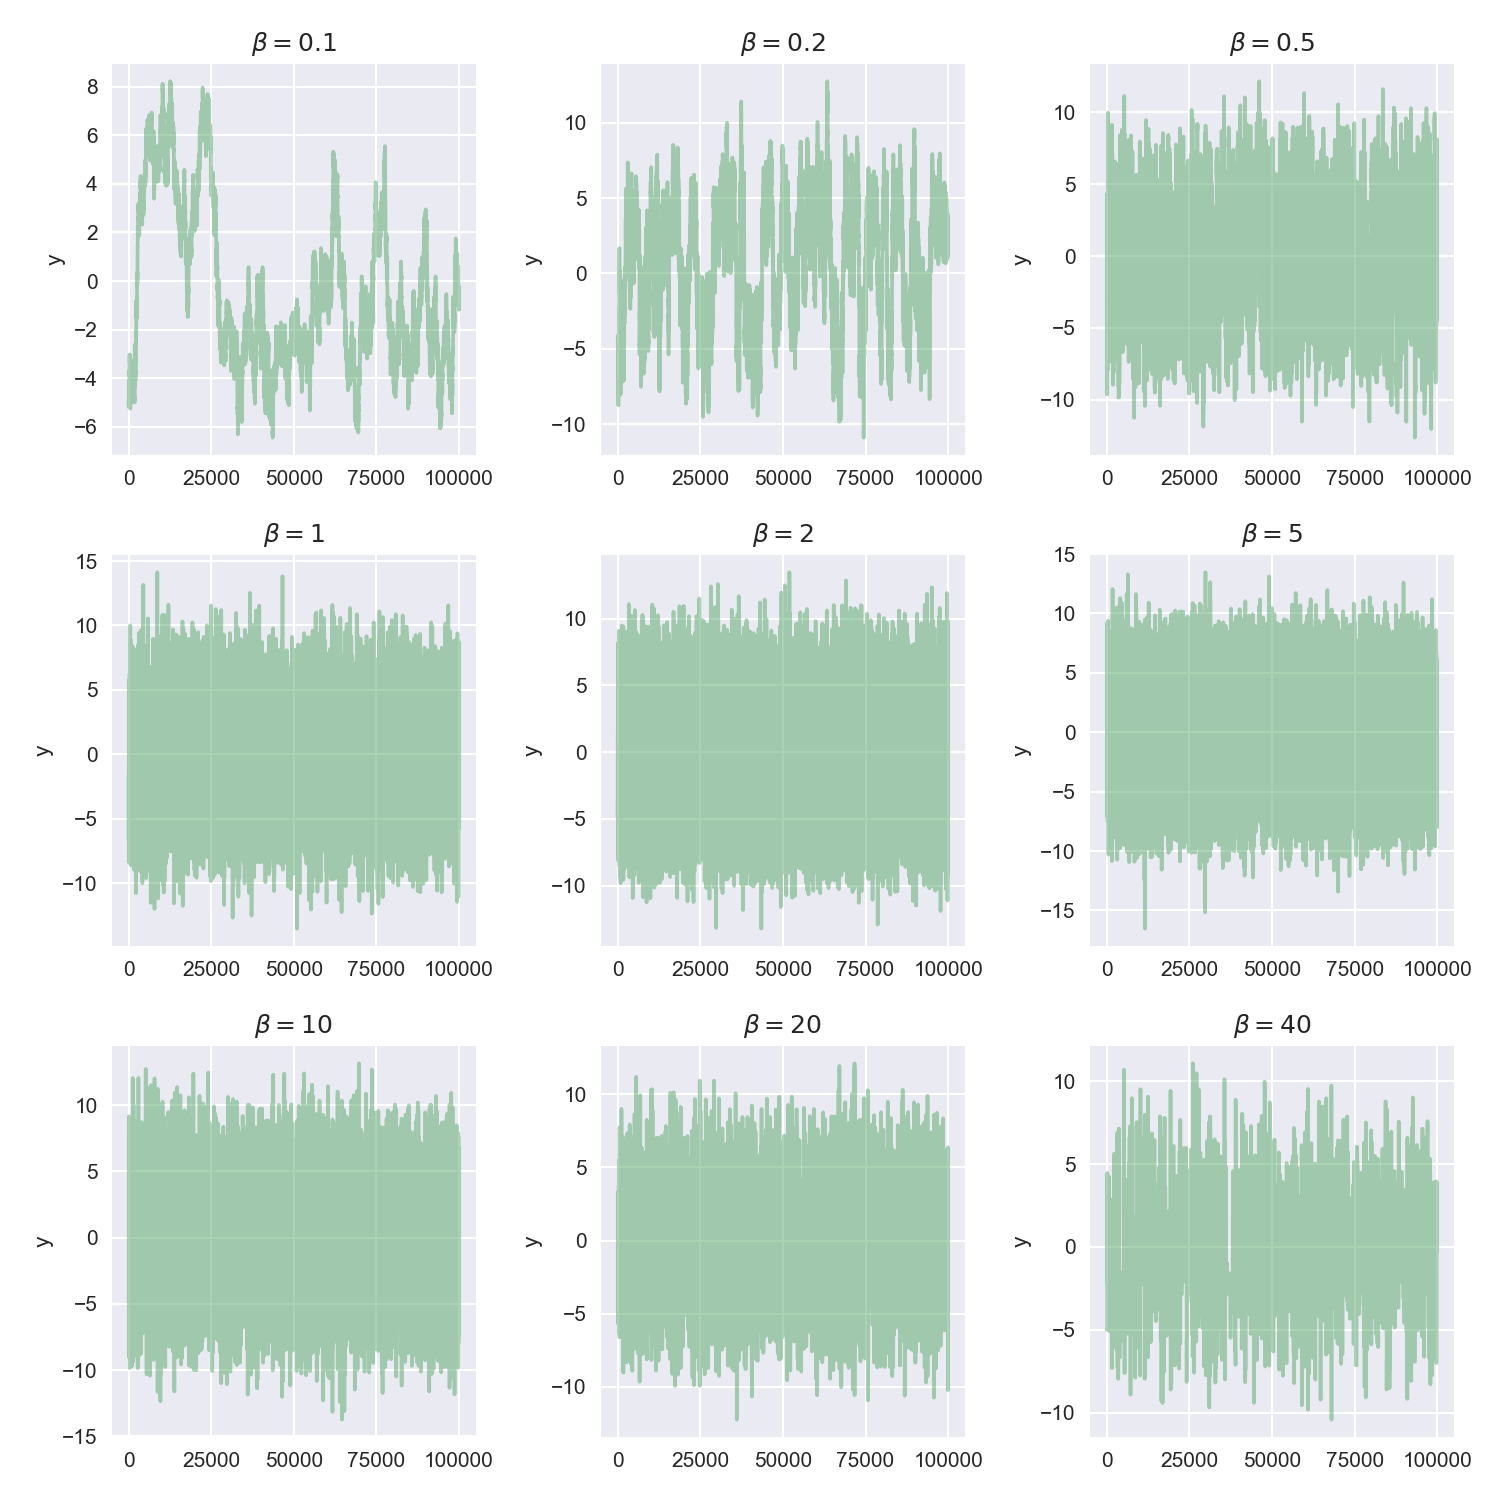

<IPython.core.display.Javascript object>


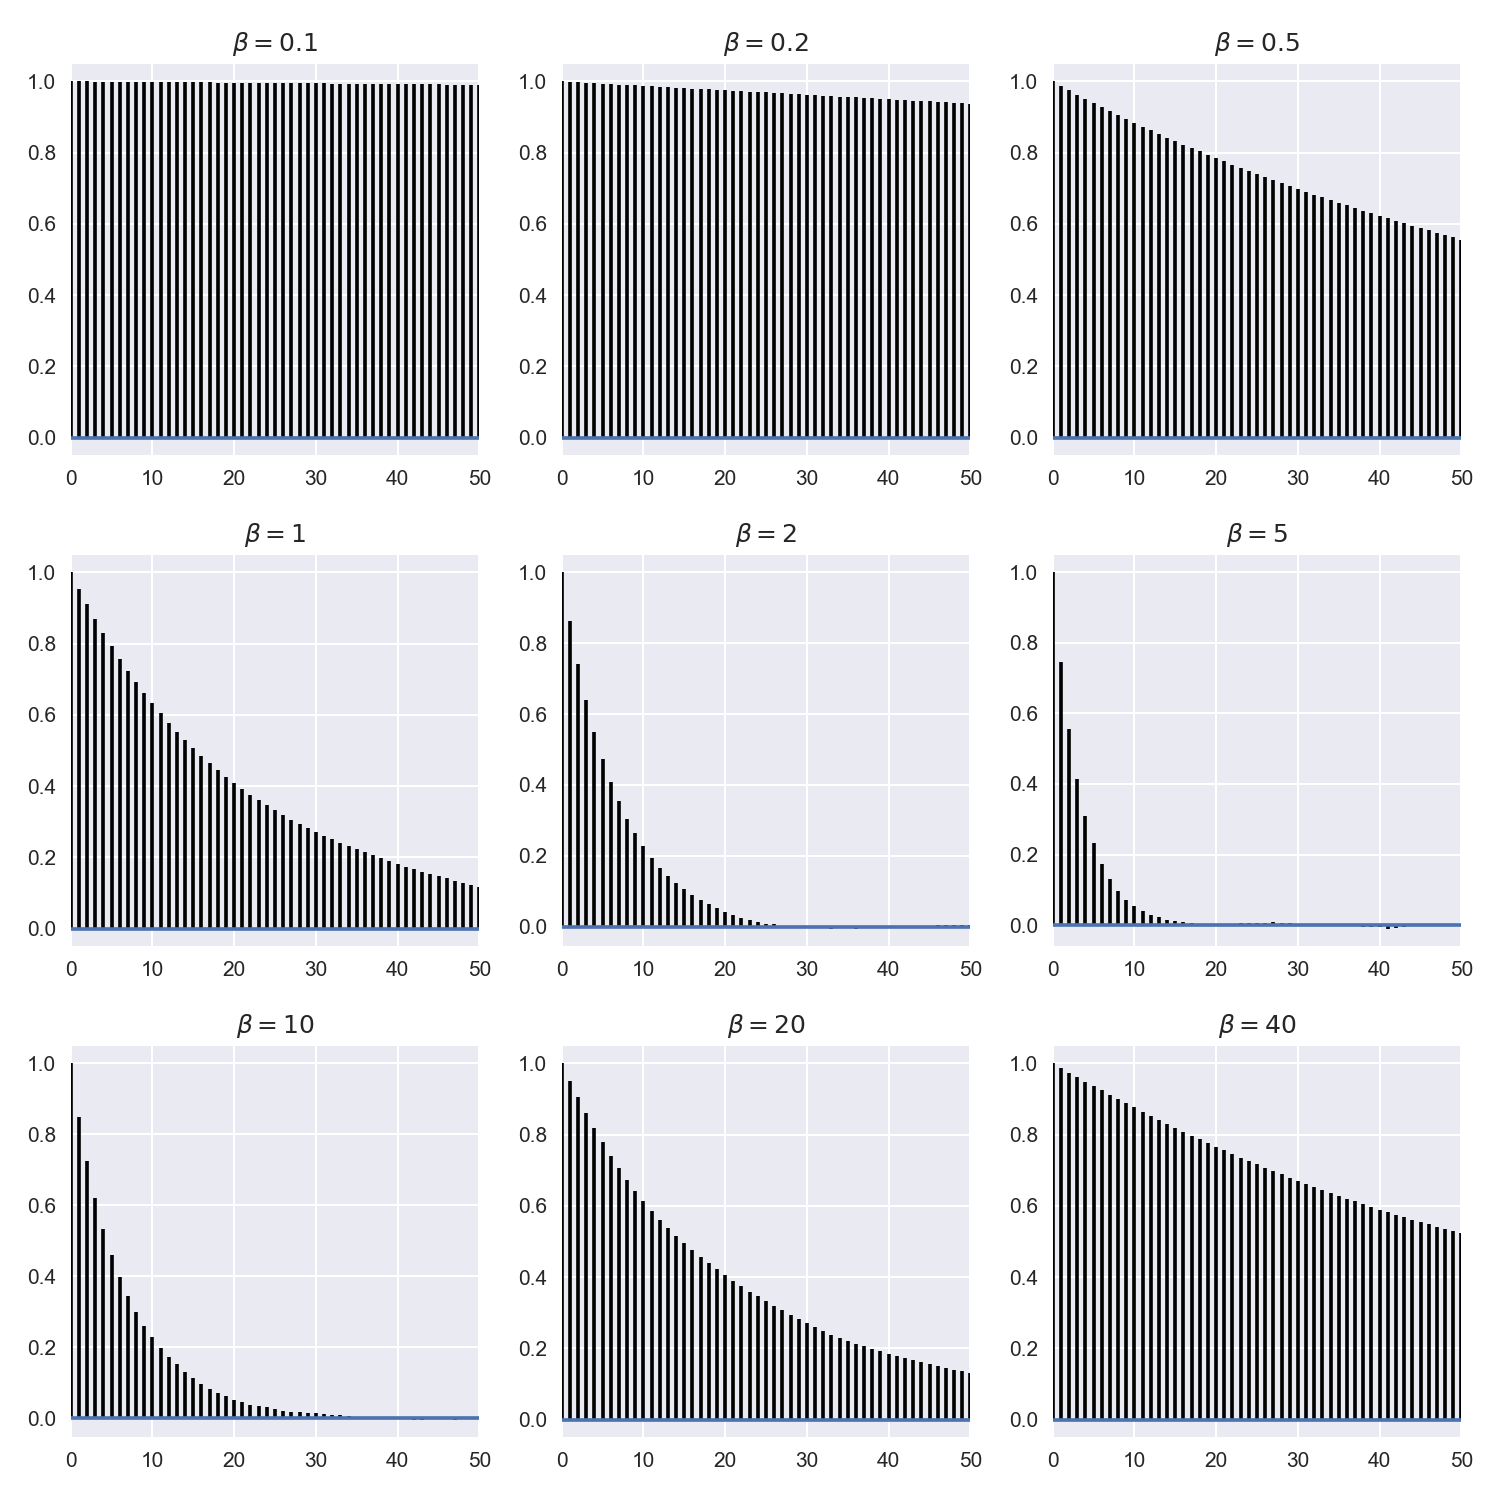

In [161]:
# Make trace plot of y and check autocorrelation for each beta 

maxlags = 50
fig1, axes1 = plt.subplots(3, 3, figsize=(10, 10))
fig2, axes2 = plt.subplots(3, 3, figsize=(10, 10))

for i in range(len(all_results)):
    samps = all_results[i][1]
    Y = np.array(samps)[:, 1]
    
    ax = axes1.flatten()[i]
    ax.plot(Y, 'C1', alpha=0.5)
    ax.set_ylabel('y')
    ax.set_title(r'$\beta=%s$' % (all_results[i][0]))
    
    ax = axes2.flatten()[i]
    ax.acorr(Y-np.mean(Y),  normed=True, maxlags=maxlags);
    ax.set_xlim([0, maxlags])
    ax.set_title(r'$\beta=%s$' % (all_results[i][0]))

fig1.tight_layout()    
fig2.tight_layout()    
plt.show()

<IPython.core.display.Javascript object>


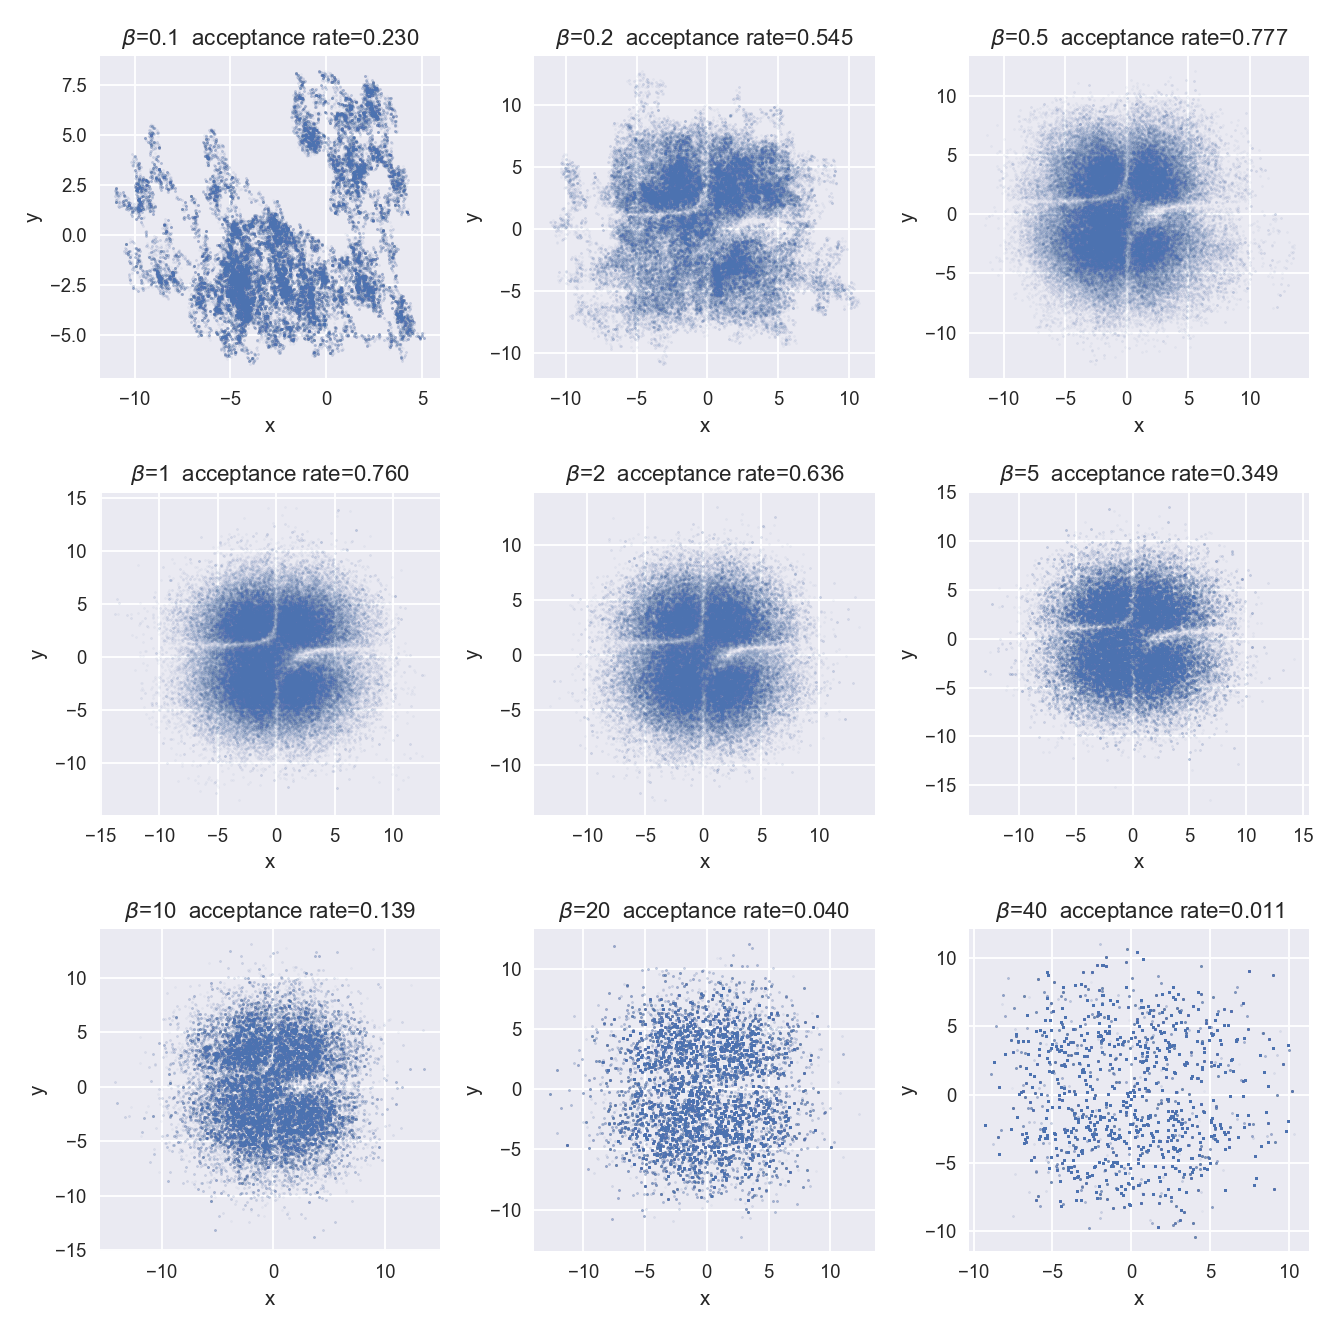

In [156]:
# Plot results (samples and acceptance rate) for each beta

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(len(all_results)):
    samps = all_results[i][1]
    X = np.array(samps)[:, 0]
    Y = np.array(samps)[:, 1]
    
    ax = axes.flatten()[i]
    ax.scatter(X, Y, s=1, alpha=0.05)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(r'$\beta$=%s  acceptance rate=%.3f' % (all_results[i][0], all_results[i][2]/N))

fig.tight_layout()    
plt.show()

We experimented with $\beta = 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 40$. For each $\beta$, we plotted the trace plots of x and y and checked the autocorrelations. We also plotted the sampling restuls and reported the acceptance rate. 

We observed that the acceptance rate first increases and then decreases with $\beta$. The highest acceptance rate is 0.777 when $\beta=0.5$. From the trace plots, we can tell there is clear structure when $\beta$ is too small or too large. The autocorrelation plots also confirmed this. Among the reasonable $\beta$'s ($\beta=2,5,10$), the "best" one is 5, since the autocorrelation decays within lag~20.
***

### Part C:

Choose a symmetric proposal and construct a Metropolis algorithm to product $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.  How do the results compare to those from Metropolis-Hastings in **Parts A & B**?  

***

### *Solution*

In [163]:
# Choose a symmetric proposal: bivariate normal centered in origin 
def q_draw_symmetric(x_old, beta):
    gamma1 = beta
    gamma2 = 1.5*beta
    mean = np.array([0., 0.])
    cov = np.array([[gamma1**2, 0], [0, gamma2**2]])
    return x_old + multivariate_normal.rvs(mean=mean, cov=cov)

In [171]:
# Again, run the metropolis code with beta in range [0.1, 40]

all_results_Metropolis = []

N = 100000
x_init = np.array([5, -5])

for beta in [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 40]:
    samps, acc = metropolis(F, partial(q_draw_symmetric, beta=beta), N, x_init)
    all_results_Metropolis.append([beta, samps, acc])

<IPython.core.display.Javascript object>


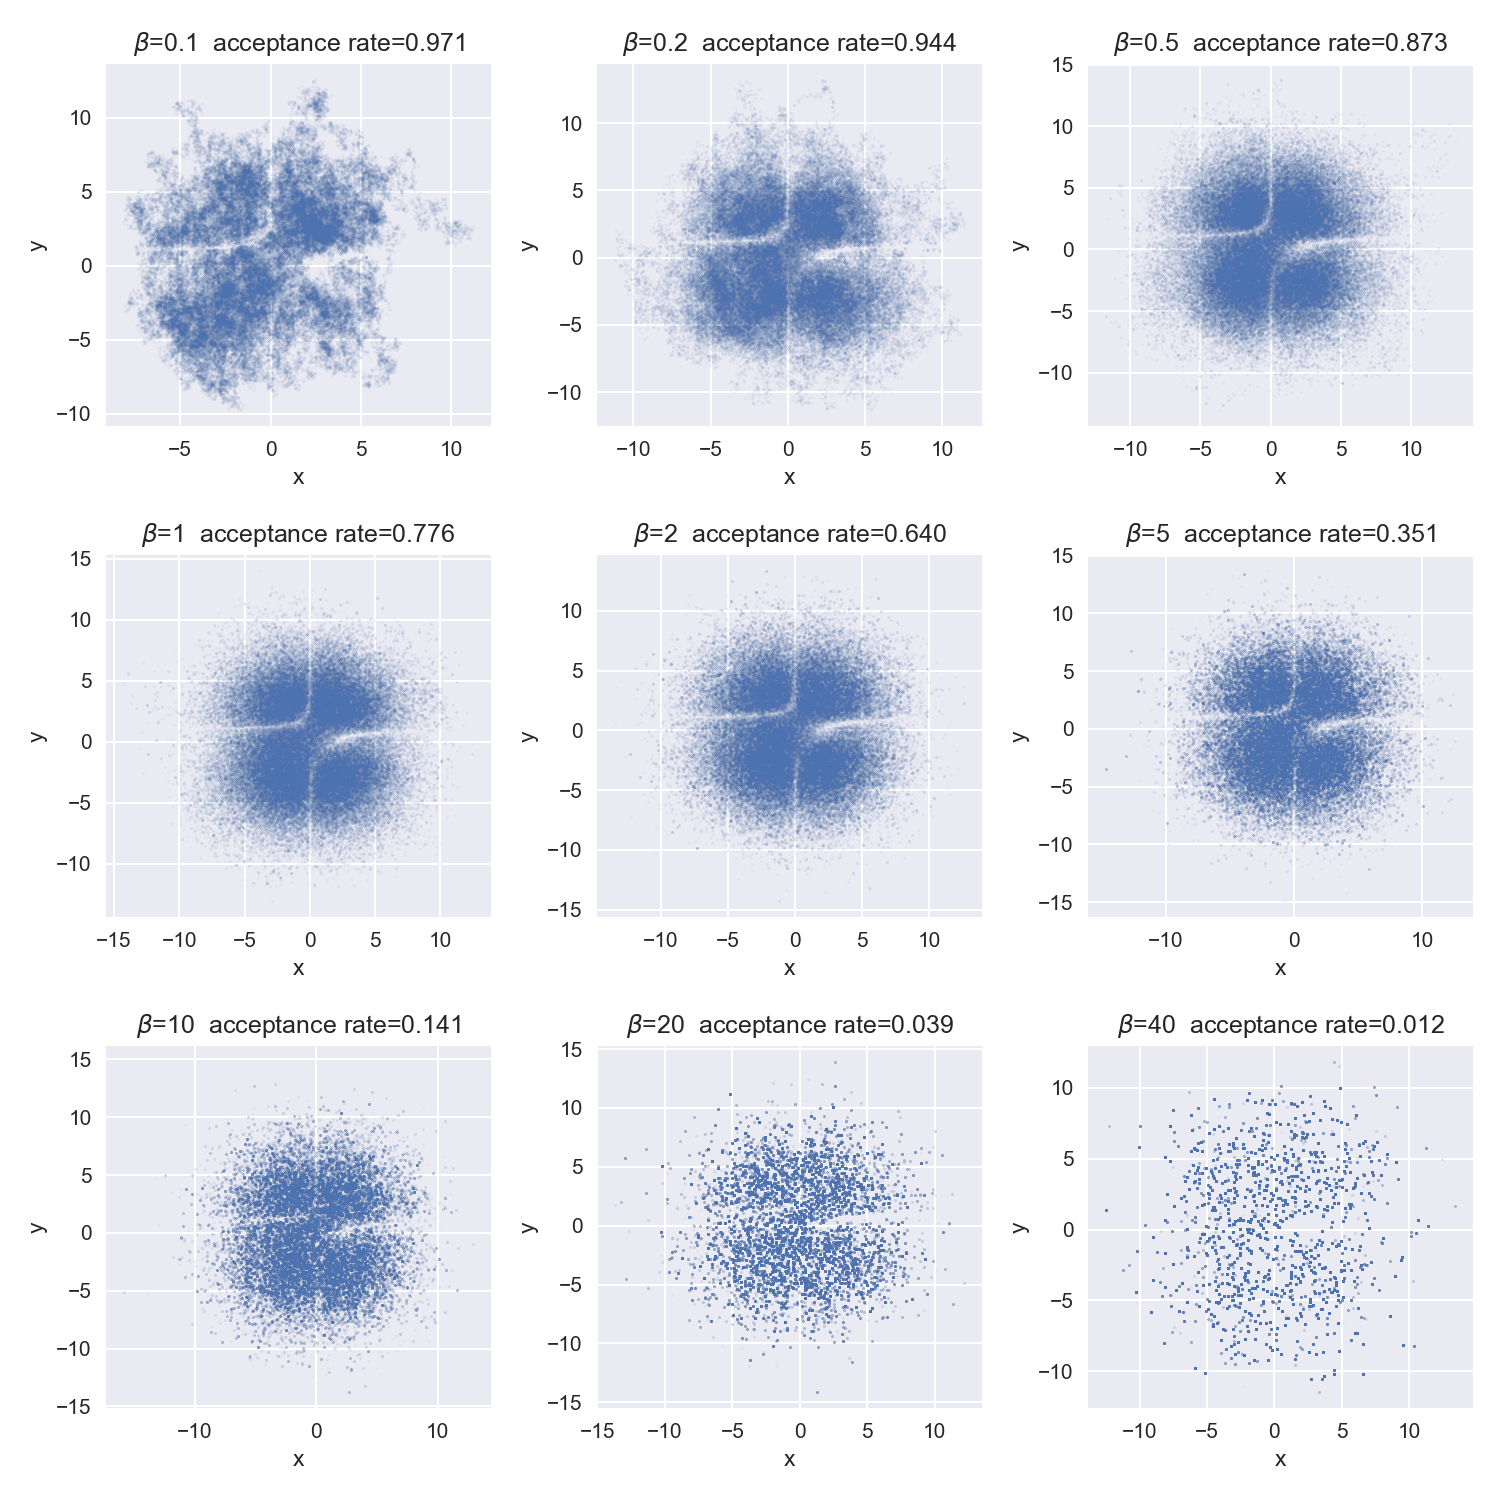

In [172]:
# Plot results (samples and acceptance rate) for each beta

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(len(all_results_Metropolis)):
    beta, samps, acc = all_results_Metropolis[i]
    X = np.array(samps)[:, 0]
    Y = np.array(samps)[:, 1]
    
    ax = axes.flatten()[i]
    ax.scatter(X, Y, s=1, alpha=0.05)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(r'$\beta$=%s  acceptance rate=%.3f' % (beta, acc/N))

fig.tight_layout()    
plt.show()

<IPython.core.display.Javascript object>


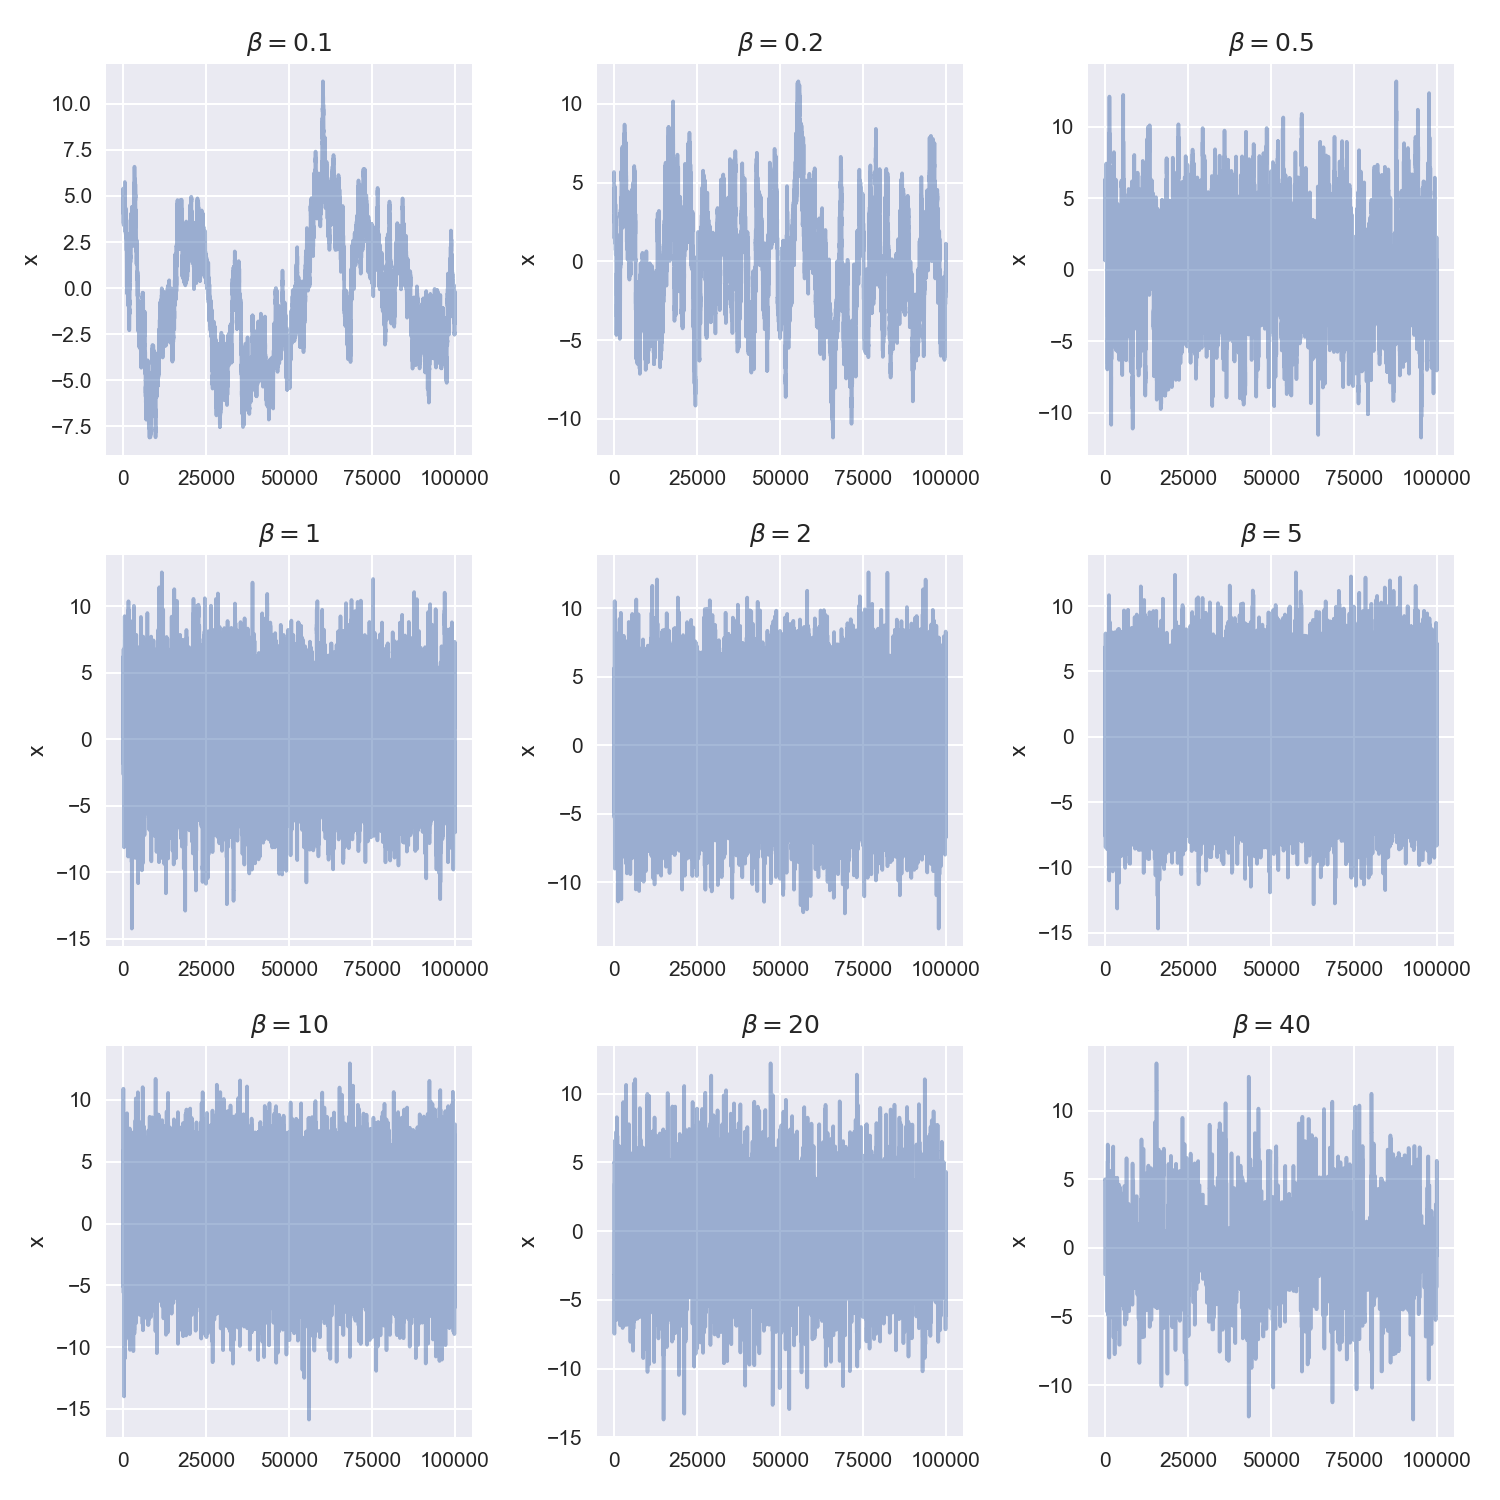

<IPython.core.display.Javascript object>


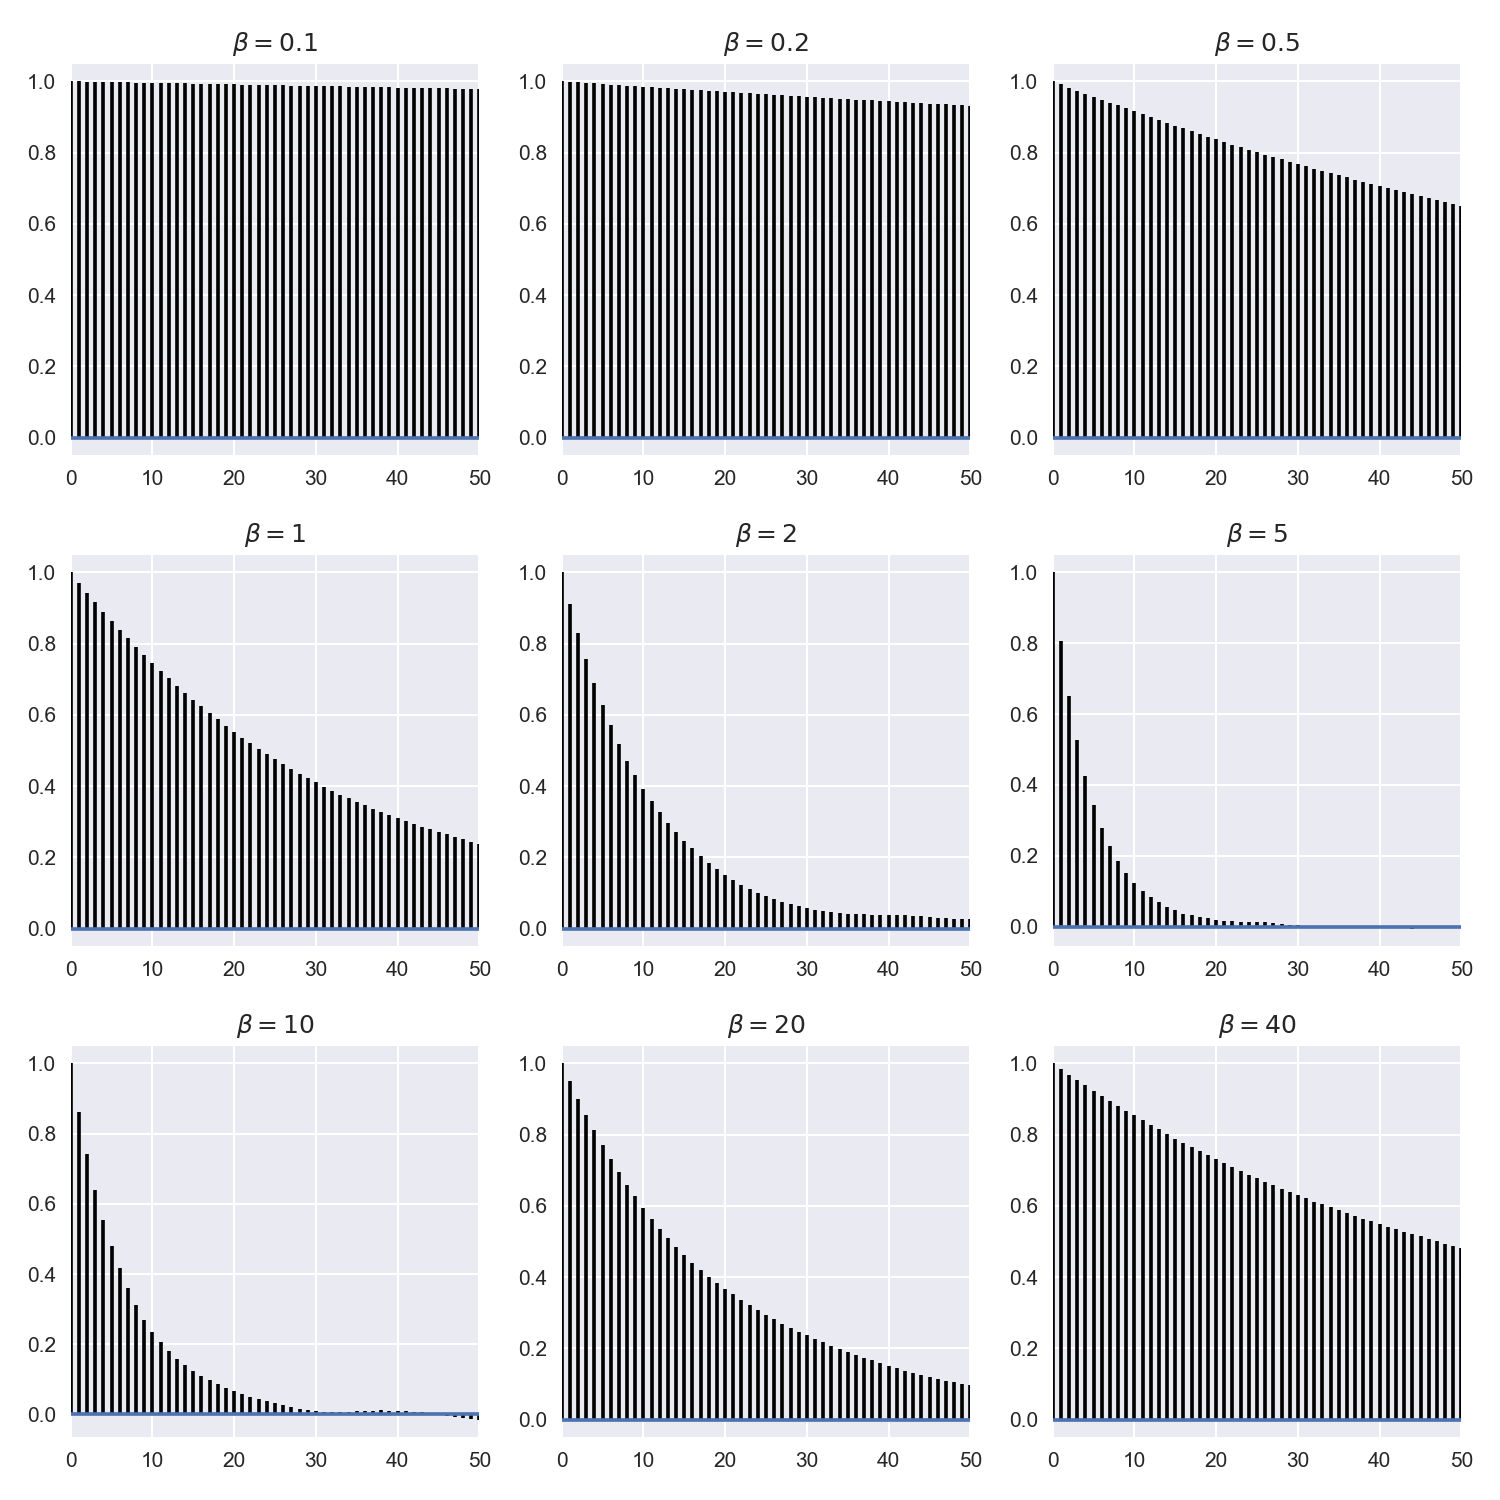

In [174]:
# Make trace plot of x and check autocorrelation for each beta 

maxlags = 50
fig1, axes1 = plt.subplots(3, 3, figsize=(10, 10))
fig2, axes2 = plt.subplots(3, 3, figsize=(10, 10))

for i in range(len(all_results_Metropolis)):
    beta, samps, acc = all_results_Metropolis[i]
    X = np.array(samps)[:, 0]
    
    ax = axes1.flatten()[i]
    ax.plot(X, alpha=0.5)
    ax.set_ylabel('x')
    ax.set_title(r'$\beta=%s$' % (beta))
    
    ax = axes2.flatten()[i]
    ax.acorr(X-np.mean(X),  normed=True, maxlags=maxlags);
    ax.set_xlim([0, maxlags])
    ax.set_title(r'$\beta=%s$' % (beta))

fig1.tight_layout()    
fig2.tight_layout()    
plt.show()

We chose a bivariate normal with 0 mean and the same covariance as used in MH to be our symmetric proposal distribution in Metropolis algorithm. Again, we experimented with different $\beta$'s.


Overall, the sampling results are similar to those in MH. The best value of $\beta$ is also $\beta=5$ using Metropolis. However, by investigating the autocorrelation, we found the autocorrelation with $\beta=1, 2, 5$ decays slightly faster in MH than in Metropolis. 

Another difference is that the acceptance rate displays a pure decreasing trend with increasing $\beta$ in Metropolis, while the acceptance rate first increases and then decreases in MH. This may be explained by the control of the stepsize. In metropolis, the stepsize is controlled by the variance of the symmetric proposal, which is just $\beta$. In MH, the proposal distribution has nonzero mean=(0.1, 0.1), hence $\beta$ is not the dominant control of the stepsize when it is smaller than or about the same order of magnitude as the mean. 
***